# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=10,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -1-0.3 log(t)$ <br> 
$\beta_{1} = -log([0.8, 3, 3, 2.5, 2])$ <br> 
$\alpha_{2t} = -1.75-0.15 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 4, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
n_patients = 20000
n_cov = 5
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
284,284,0.049500,0.101855,0.134174,0.316541,0.298750,1,1,28,1
17658,17658,0.579743,0.986458,0.838584,0.069820,0.700837,1,2,25,2
14914,14914,0.993004,0.287427,0.277104,0.095866,0.697631,0,21,2,2
8659,8659,0.442383,0.085983,0.214822,0.377323,0.521320,1,12,30,12
11818,11818,0.335444,0.051806,0.636391,0.151979,0.948199,1,16,24,16


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, ... , T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               144115
Model:                            GLM   Df Residuals:                   144080
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21603.
Date:                Thu, 10 Mar 2022   Deviance:                       43206.
Time:                        10:23:30   Pearson chi2:                 1.43e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01404
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -1.1012  

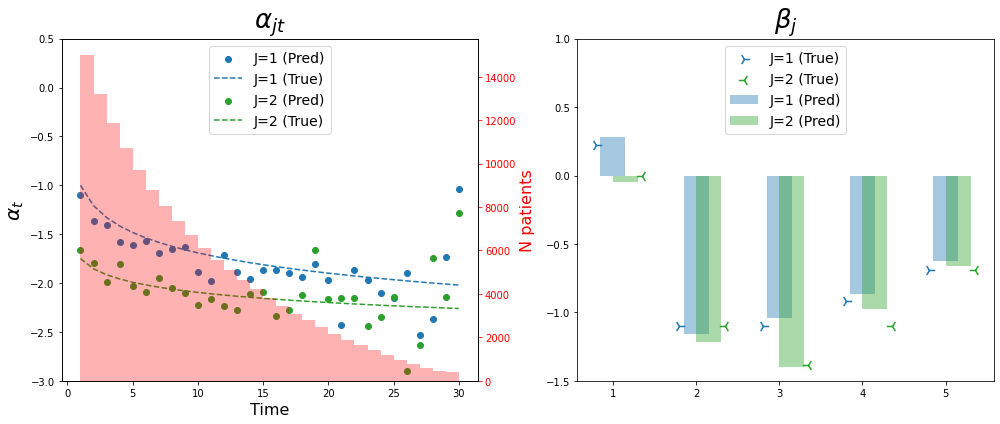

In [4]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=times, expanded_train_df=fitter.expanded_df, 
                       n_cov=5)

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [5]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 144115 total observations, 138841 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 144115
number of events observed = 5274
   partial log-likelihood = -46867.25
         time fit was run = 2022-03-10 08:23:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.27       1.31       0.05             0.18             0.37                 1.20                 1.44
Z2         -1.13       0.32       0.05            -1.22            -1.03                 0.29                 0.36
Z3         -1.01       0.36       0.05            -1.11            -0.92                 0.33                 0.40
Z4         -0.84       0.43       0.05            -0.94            -0.75                 0.39                 0.47
Z5         -0.61       0.54       0.05            -0.70            -0.51                 0.50                 0.60

               z      p   -log2(p)
covariate                         
Z1          5.69 <0.005      26.27
Z2        -22.96 <0.005     385.07
Z3        -20.77 <0.005     316.02
Z4        -17.65 <0.005     229.23
Z5        -12.72 <0.005     120.73
---
Concordance = 0.64
Partial AIC = 93744.50
log-likelihood ratio test = 1364.04 on 5 df
-log2(p) of ll-ratio test = 970.23

None


n_jt  success  alpha_jt
J X                          
1 1    972     True -1.138185
  2    650     True -1.401637
  3    548     True -1.449276
  4    414     True -1.615627
  5    357     True -1.647586
  6    330     True -1.610800
  7    265     True -1.729944
  8    247     True -1.694430
  9    226     True -1.673790
  10   160     True -1.921980
  11   132     True -2.014793
  12   154     True -1.757927
  13   117     True -1.927198
  14    98     True -1.995922
  15    96     True -1.904050
  16    85     True -1.909643
  17    73     True -1.941962
  18    63     True -1.975605
  19    63     True -1.847006
  20    47     True -2.002913
  21    26     True -2.460615
  22    39     True -1.909232
  23    30     True -2.004461
  24    22     True -2.146681
  25    17     True -2.198695
  26    17     True -1.939946
  27     7     True -2.560881
  28     6     True -2.416565
  29     7     True -1.784496
  30     6    False  0.000000



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 144115 total observations, 141726 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 144115
number of events observed = 2389
   partial log-likelihood = -21040.09
         time fit was run = 2022-03-10 08:23:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1         -0.04       0.96       0.07            -0.18             0.10                 0.83                 1.10
Z2         -1.20       0.30       0.07            -1.35            -1.06                 0.26                 0.35
Z3         -1.39       0.25       0.07            -1.53            -1.24                 0.22                 0.29
Z4         -0.97       0.38       0.07            -1.11            -0.83                 0.33                 0.44
Z5         -0.65       0.52       0.07            -0.79            -0.51                 0.45                 0.60

               z      p   -log2(p)
covariate                         
Z1         -0.62   0.53       0.91
Z2        -16.45 <0.005     199.66
Z3        -18.83 <0.005     260.32
Z4        -13.58 <0.005     137.18
Z5         -9.17 <0.005      64.24
---
Concordance = 0.67
Partial AIC = 42090.18
log-likelihood ratio test = 839.50 on 5 df
-log2(p) of ll-ratio test = 592.91

None


n_jt  success  alpha_jt
J X                          
2 1    391     True -1.681624
  2    293     True -1.806235
  3    212     True -2.007768
  4    223     True -1.822238
  5    159     True -2.048672
  6    133     True -2.109413
  7    137     True -1.969723
  8    111     True -2.072054
  9     95     True -2.113202
  10    75     True -2.237058
  11    72     True -2.178616
  12    61     True -2.239695
  13    52     True -2.281464
  14    55     True -2.125448
  15    50     True -2.107739
  16    35     True -2.327714
  17    33     True -2.271780
  18    34     True -2.136839
  19    47     True -1.678384
  20    25     True -2.171633
  21    22     True -2.159960
  22    19     True -2.162432
  23    12     True -2.458882
  24    11     True -2.343393
  25    11     True -2.155335
  26     4     True -2.856926
  27     4     True -2.633128
  28     7     True -1.769025
  29     3     True -2.163510
  30     3    False  0.000000

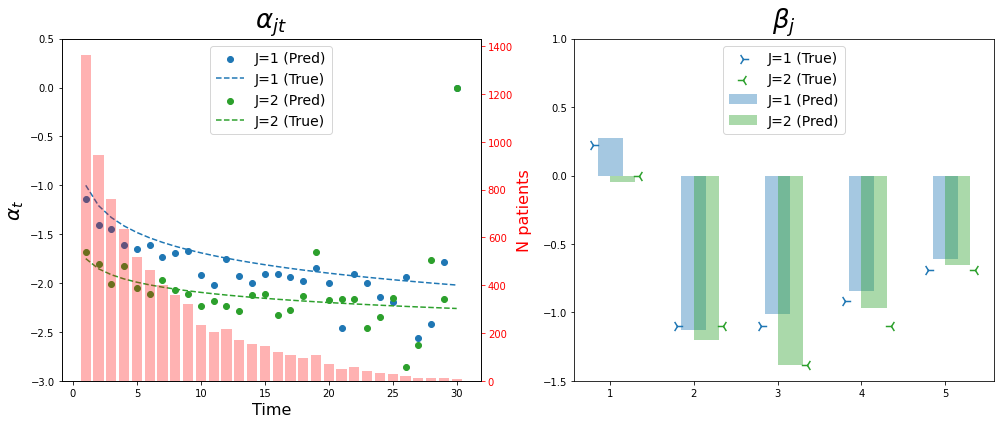

In [6]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(fitter.alpha_df, fitter.beta_models, times, n_cov=5)

In [7]:
fitter.get_beta_SE()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.273162,0.047970,-0.044322,0.071192
Z2,-1.125861,0.049039,-1.204750,0.073219
Z3,-1.014737,0.048846,-1.387050,0.073664
Z4,-0.842094,0.047706,-0.966089,0.071125
Z5,-0.608103,0.047803,-0.652057,0.071085


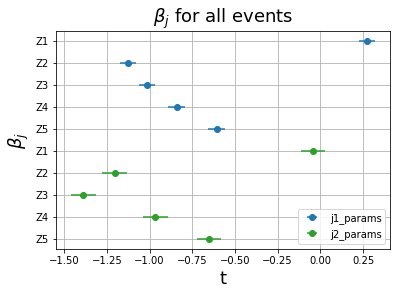

<AxesSubplot:title={'center':'$\\beta_{j}$ for all events'}, xlabel='t', ylabel='$\\beta_{j}$'>

In [8]:
fitter.plot_all_events_beta()

## Prediction

In [9]:
pred_df = fitter.predict_cumulative_incident_function(test_df)
pred_df = fitter.predict_marginal_prob_all_events(pred_df)
pred_df.set_index(['pid']).head().T

pid,19367,7287,19974,10275,357
Z1,7.811500e-01,8.874464e-01,4.474753e-01,1.805010e-01,2.663704e-01
Z2,4.804939e-01,9.826043e-01,1.406798e-01,9.088734e-01,3.685989e-01
Z3,4.571418e-01,1.805090e-02,6.949342e-02,3.735219e-01,2.192794e-01
Z4,7.207327e-01,5.881995e-01,1.889738e-01,5.528997e-01,7.890379e-01
Z5,7.307463e-01,9.540523e-02,9.534481e-01,1.869455e-01,1.442401e-01
J,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
T,3.000000e+01,2.000000e+00,2.000000e+00,8.000000e+00,7.000000e+00
C,1.200000e+01,9.000000e+00,2.300000e+01,9.000000e+00,1.100000e+01
X,1.200000e+01,2.000000e+00,2.000000e+00,8.000000e+00,7.000000e+00
X_copy,1.200000e+01,2.000000e+00,2.000000e+00,8.000000e+00,7.000000e+00


## Comparison (WIP)

In [10]:
pd.DataFrame(index=pd.MultiIndex.from_product([['d=30', 'd=60', 'd=100', 'd=150'],
                                               ['N=1000', 'N=10000', 'N=100000']], names=['N', 'D']), 
             columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

Train MSE (oracle) Test MSE (oracle) computation time
N     D                                                             
d=30  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=60  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=100 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=150 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN